In [7]:
import qiskit

import numpy as np
from qiskit.quantum_info import Pauli
from qiskit_nature.operators.second_quantization import FermionicOp

# the JKMN transform 

The research on Fermion to Qubit mappings is still active. One of the most recent developments is dated Oct 2019 ([arXiv:1910.10746](https://arxiv.org/abs/1910.10746)).
In this paper, Zhang Jiang and collaborators propose an elegant method based on ternary trees to achieve average locality of transformed single fermionic operators to $\lceil{\log_3(n)}\rceil$ for a $n$-mode fermionic system.
The authors also prove this method to be *optimal*: no general fermion to qubit mapping using $n$ qubits can do better than this.

It is beyond the scope of this tutorial to explain the whole transform, but we give some concepts that can be useful if one wants to delve deeper into it.


### Majorana representation of Fermionic operators

To perform the JKMN transform we first have to rewrite the fermionic operators in term of **Majorana operators**, defined as
$$
    \gamma_{2j} = c^\dagger_j + c_j,\\
    \gamma_{2j+1} = i( c^\dagger_j - c_j ).
$$
These operators behave much like generalizations of Pauli operators: they are Hermitian and unitary, thus squaring to the identity $\gamma_j^2=\mathbb{1}$, and they all anticommute with each other ($\{\gamma_j, \gamma_k\} = 2\delta_{j,k}$).
For a single-mode system, their matrix representation also looks like Pauli matrices (note that the last matrix is obtained by the product of all the previous ones):

In [8]:
gamma_0 = FermionicOp(("+",1)) + FermionicOp(("-",1))
gamma_1 = FermionicOp(("+",1j)) - FermionicOp(("-",1j))

print("gamma_0 = c^+ + c \n", gamma_0.to_matrix(sparse=True).A , '\n(same form as Pauli X)\n')

print("gamma_1 = i(c^+ - c) \n", gamma_1.to_matrix(sparse=True).A , '\n(same form as Pauli Y)\n')

print('-i * gamma_0 * gamma_1 \n',(-1j*gamma_0.to_matrix() * gamma_1.to_matrix()).A, '\n(same form as Pauli Z)\n')    

AttributeError: 'FermionicOp' object has no attribute 'to_matrix'

An operator in an $n$-mode fermionic system can be rewritten by choosing among $2n$ Majorana operators (sometimes also called Majorana modes).

*Sidenote*: all transformations can be defined in terms of Majorana operators (as they're just a re-writing of fermionic operators). For JKMN this is specially useful.

### The ternary tree construction

Let's suppose that the number of fermionic modes in our system is $n = (3^m-1)/2$ (the extension to a generic $n$ is technical but conceptually simple).
The number of Majorana modes will then be $3^m-1$.
Let's now construct a **ternary tree** like in Figure 1 of the [JKMN paper](https://arxiv.org/abs/1910.10746):
we start with one root node from which 3 branches spring. At the end of every branch a new node springs 3 more branches. Repeating the operation $m$ times we obtain a tree with $3^m$ terminal nodes (or **leaf nodes**).
To each leaf node but the last one we assign one of the Majorana operators $\gamma_j$.
To each branching node (i.e. non-terminal node) we associate a qubit $Q_i$ (exercise: convince yourself that we need exactly $n$ qubits).
To each branch we associate one of the three pauli operators acting on the qubit on the node from which the branch springs $\{X_i, Y_i, Z_i\}$.
Each $\gamma_j$ will be mapped to a string of Pauli operators corresponding to the branches on the path that connect the leaf $\gamma_j$ to the root of the tree.

Mappings of $\gamma_j$ and $\gamma_{j'}$ will differ by a single different Pauli matrix on the same qubit, at the node where the paths join (plus a bunch of identities on qubits not touched by the paths.
For this reason, all transformed $\gamma_j$ will anticommute.
Also, as the number of branches on the path from any leaf to the root is $m = \log_3(2n+1)$, every majorana operator will be mapped to a $m$-local qubit operator.

### Locality scaling

The code for JKMN is not yet in openfermion, but we coded it for the tutorial and for our research. We are planning to add it to openfermion in the near future.
The code is in the module file `_jkmn.py`, which you should have downloaded from the course website. Run `import _jkmn` and `help(_jkmn)` to see the content of the module.
The function `jkmn` from this module is homologue to the `bravyi_kitaev` function of `openfermion.transforms` and requires the number of modes to be specified.

**Exercise 11:** The code below prints the `FermionOperator` objects for each of the 8 Majorana $\gamma_j$ in a $n=4$ fermionic modes system. Use JKMN to map them to QubitOperators and check the mapped operators against the tree in Figure 1 of the [JKMN paper](https://arxiv.org/abs/1910.10746).

In [1]:
from _jkmn import majorana_to_fermion, inline, jkmn
from openfermion import MajoranaOperator

n = 4
print(f'Maj |      Fermion op      |    JKMN-mapped Qubit op')
for maj_idx in range(2*n):
    fop = majorana_to_fermion(MajoranaOperator((maj_idx,)))
    qop = jkmn(fop, n)
    print(f'{maj_idx:^3} | {inline(fop):^20} | {inline(qop):^25}')

Maj |      Fermion op      |    JKMN-mapped Qubit op
 0  |  1.0 [0] + 1.0 [0^]  |        1.0 [X0 X1]       
 1  |   1j [0] - 1j [0^]   |      (1+0j) [X0 Y1]      
 2  |  1.0 [1] + 1.0 [1^]  |        1.0 [X0 Z1]       
 3  |   1j [1] - 1j [1^]   |      (1+0j) [Y0 X2]      
 4  |  1.0 [2] + 1.0 [2^]  |        1.0 [Y0 Y2]       
 5  |   1j [2] - 1j [2^]   |      (1+0j) [Y0 Z2]      
 6  |  1.0 [3] + 1.0 [3^]  |        1.0 [Z0 X3]       
 7  |   1j [3] - 1j [3^]   |      (1+0j) [Z0 Y3]      


In [ ]:
majorana_to_fermion(MajoranaOperator((1,3)))#.terms.items()

(1+0j) [0^ 1] +
(1+0j) [1 0] +
(-1+0j) [1^ 0] +
(1+0j) [1^ 0^]

## Analyze the JKMN implementation of Rossi

In [12]:



def nodeindex(p,l):
    """Returns index of a node of depth l on the path p on the ternary tree of height h.
    Ternary tree is just a string of natural numbers starting from 0 ordered in a tree where
    each node has three children. For image and formula see arXiv:1910.10746, Eq. (3).
    Args:
        p (list): list of strings of integers 0,1 or 2 of length h
        l (int): depth of tree to calculate the index on, l <= h
    Returns:
        int: index of a node corresponding to a qubit number
    """
    h = len(p)
    assert l <= h, "should be l <= h, where h = len(p)"
    for idx in p:
        assert (idx == '0') or (idx == '1') or (idx == '2'), "indices should be 0,1 or 2"
    
    prefactor = (3**l - 1)/2 
    sumfactors = [3**(l-1-j)*int(p[j]) for j in range(l)]
    return int(prefactor + sum(sumfactors))

def hfromnum_qubits(num_qubits):
    """Calculates the needed height of the tree from number of qubits.
    Args:
        num_qubits (int): number of qubits
    
    Returns:
        height (int): required height of the ternary tree.
    """
    height = np.ceil(np.log(2*num_qubits+1)/np.log(3)) # base 3 logarithm
    return int(height) # integererize the output
    
def xyzstring(h):
    """Generate a list of repeating 'X','Y','Z' pattern to fill the ternary tree.
    Args:
        h (int): Height of the ternary tree
    Returns:
        list: List of strings ['null', 'X','Y','Z','X','Y,'Z','X',...]
    """
    num_idxs = int((3**h - 1) // 2) # number of indices (qubits) to add
    num_idxs_triplets = int(num_idxs / 3) # number of triplets 
    output = ['null'] # add an index for the 0th qubit
    for _ in range(num_idxs_triplets):
        output += ['X','Y','Z']
    return output 
def paulipaths_full(h):
    """Generate all Pauli paths from a tree of height h.
    
    
    Args:
        h (int): height of the ternary tree
    Returns:
        list: List of Pauli strings
    """
    xyzs = xyzstring(h+1) # generate the xyz string for tree height + 1
    num_qubits = int((3**(h) - 1) // 2) # get number of qubits from the height
    # generate all paths by looping over the number of paths in ternary base 
    paths = []
    for i in range(3**(h)):
        paths += [np.base_repr(i,base=3).rjust(h,'0')]
    
    # generate the Pauli strings from paths by substituting I with appropriate Pauli gate
    paulistrings = []
    for path in paths:
        pstring = ['I']*num_qubits # initialize a string with I's
        # for each depth, get the index at which the IIII.. path should be substituted and 
        # idx2 at which the substitution Pauli is located
        for depth in range(h):
            idx = nodeindex(path,depth)
            idx2 = nodeindex(path,depth+1)
            pstring[idx] = xyzs[idx2]
        # add the resulting string to the list, converted from string to list
        paulistrings += ["".join(pstring)]
    return paulistrings
def paulipaths(num_qubits):
    # Step 1: Introduce a complete ternary tree with height h
    h = hfromnum_qubits(num_qubits) # get tree max height
    
    # generate two full trees, the larger one should 
    # accommodate all qubits
    pphm1 = paulipaths_full(h-1)
    pph = paulipaths_full(h)
    
    # get number of qubits in the smaller tree 
    # and the number of extra qubits
    n_qubits_hm1 = len(pphm1[0])
    n_extraqubits = num_qubits - n_qubits_hm1
    paulistrings = []
    # loop over each gate in the larger tree for extra qubits 
    # to add the extra paths, also truncate the added paths 
    # up to the real number of qubits,
    # then add the path, converted to a Pauli object
    for i in range(n_extraqubits * 3):
        path = pph[i][:n_qubits_hm1 + n_extraqubits]
        # print(path)
        paulistrings += [Pauli(path[::-1])]
        
        # paulistrings += path
    # loop over each gate in the smaller tree, skipping over 
    # the first gates of extra qubits, also add extra 'I' gates,
    # then add the path, converted to a Pauli object
    for i in range(n_extraqubits, len(pphm1)):
        path = ''.join([pphm1[i]] + ['I'] * n_extraqubits)
        paulistrings += [Pauli(path[::-1])]
        # paulistrings += path
    return paulistrings
def nevenrun(n):
    # reshape the pauli strings from a list into a paired list, skipping the very last one
    allpaths = paulipaths(num_qubits=n)
    paths = [(allpaths[2*k],allpaths[2*k + 1]) for k in range(int((len(allpaths)-1)//2))] 
    return paths, allpaths


In [4]:
print('height of a tree of qubits (height,qubits):',[(hfromnum_qubits(n),n) for n in range(1,14)])
num_qubits =4
h = hfromnum_qubits(num_qubits)

pphm1 = paulipaths_full(h-1)
pphm2 = paulipaths_full(h)
print('generate a tree of height = ',h-1, pphm1)
print('generate a tree of height = ',h, pphm2)




n_qubits_hm1 = len(pphm1[0])
n_extraqubits = num_qubits - n_qubits_hm1
paulistrings = []
print('Qubits: small tree',n_qubits_hm1,'large tree',num_qubits, 'n_extraqubits',n_extraqubits)
for i in range(n_extraqubits * 3):
        path = pphm2[i][:num_qubits]
        print(path)
        paulistrings += [Pauli(path)]

print('next',range(n_extraqubits, len(pphm1)))

for i in range(n_extraqubits, len(pphm1)):
    path = ''.join([pphm1[i]] + ['I'] * n_extraqubits)
    print(path)
    paulistrings += [Pauli(path)]

paulistrings2 = []
print('my test')
for i in range(n_extraqubits):
    for j,sigma in enumerate(['X','Y','Z']):
        path = ''.join([pphm1[i]] + ['I'] * n_extraqubits)
        index = n_qubits_hm1+i
        path=path[:index] + sigma + path[index + 1:]
        print(path)
        paulistrings2 += [Pauli(path)]

print('final', paulistrings)
print('final', paulistrings2)

height of a tree of qubits (height,qubits): [(1, 1), (2, 2), (2, 3), (2, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13)]
generate a tree of height =  1 ['X', 'Y', 'Z']
generate a tree of height =  2 ['XXII', 'XYII', 'XZII', 'YIXI', 'YIYI', 'YIZI', 'ZIIX', 'ZIIY', 'ZIIZ']
Qubits: small tree 1 large tree 4 n_extraqubits 3
XXII
XYII
XZII
YIXI
YIYI
YIZI
ZIIX
ZIIY
ZIIZ
next range(3, 3)
my test
XXII
XYII
XZII
YIXI
YIYI
YIZI
ZIIX
ZIIY
ZIIZ
final [Pauli('XXII'), Pauli('XYII'), Pauli('XZII'), Pauli('YIXI'), Pauli('YIYI'), Pauli('YIZI'), Pauli('ZIIX'), Pauli('ZIIY'), Pauli('ZIIZ')]
final [Pauli('XXII'), Pauli('XYII'), Pauli('XZII'), Pauli('YIXI'), Pauli('YIYI'), Pauli('YIZI'), Pauli('ZIIX'), Pauli('ZIIY'), Pauli('ZIIZ')]


### Test the JKMN Converter in "from JKMN_mapper import JKMNMapper"

In [3]:
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
from qiskit_nature.drivers.second_quantization.pyscfd import PySCFDriver
from qiskit_nature.drivers import UnitsType
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from JKMN_mapper import JKMNMapper


## Testin
from qiskit.algorithms.optimizers import L_BFGS_B,SPSA, COBYLA
from qiskit_nature.algorithms import VQEUCCFactory, GroundStateEigensolver,NumPyEigensolverFactory,ExcitedStatesEigensolver
from qiskit.utils import QuantumInstance
from qiskit.providers import aer
from qiskit.circuit.library.n_local import TwoLocal
from qiskit_nature.circuit.library import UCCSD,UCC,PUCCD,EvolvedOperatorAnsatz
from qiskit.circuit.library import EvolvedOperatorAnsatz
from qiskit.circuit import QuantumCircuit
from qiskit.algorithms import VQE
from qiskit import Aer
import numpy as np

from qiskit_nature.circuit.library.initial_states import HartreeFock


useTwoLocalAnsatz = True

if useTwoLocalAnsatz : print('using two local ansatz')
else: print('using uccsd ansatz')

distances = np.arange(0.5,1,0.5)

energies_JKMN = []
energies_JW = []
energies_exact = []

for bond_distance in distances:
    print(bond_distance)
    # Molecule
    molecule = 'H .0 .0 -{0}; H .0 .0 {0}'

    #initialize driver & electronic problem
    driver = PySCFDriver(atom=molecule.format(bond_distance/2), unit=UnitsType.ANGSTROM, basis='sto3g')
    es_problem = ElectronicStructureProblem(driver,
                                            q_molecule_transformers=[FreezeCoreTransformer(freeze_core=True, remove_orbitals=[])])


    # Initialize qubit converter
    qubit_converter_PM = QubitConverter(mapper=ParityMapper())
    qubit_converter_JKMN = QubitConverter(mapper=JKMNMapper())
    qubit_converter_JW = QubitConverter(mapper=JordanWignerMapper())
    qubit_converter_BK = QubitConverter(mapper=BravyiKitaevMapper())

    num_qubits = 4
    tl_circuit = TwoLocal(num_qubits, ['h', 'rx'], 'cz',
                        entanglement='full', 
                        reps=3, 
                        parameter_prefix = 'y')


    qmolecule = driver.run()
    num_particles = qmolecule.num_alpha,qmolecule.num_beta

    qi = QuantumCircuit(4)
    qi.x([1,3])


    hf_init_JW = HartreeFock(qubit_converter=qubit_converter_JW, 
                            num_spin_orbitals = qmolecule.num_molecular_orbitals*2, 
                            num_particles= num_particles )
    uc_circuit_JW = UCC(qubit_converter=qubit_converter_JW,
                        excitations='s',
                        num_spin_orbitals = qmolecule.num_molecular_orbitals*2, 
                        num_particles= num_particles, 
                        initial_state=hf_init_JW)
    # tl_circuit_JW = TwoLocal(num_qubits, ['h', 'rx'], 'cz',
                            #  entanglement='full', 
                            #  reps=3, 
                            #  parameter_prefix = 'y',
                            #  initial_state=hf_init_JW)

    hf_init_JKMN = HartreeFock(qubit_converter=qubit_converter_JKMN, 
                            num_spin_orbitals = qmolecule.num_molecular_orbitals*2, 
                            num_particles= num_particles)
    uc_circuit_JKMN = UCC(qubit_converter=qubit_converter_JKMN, 
                        excitations='s',
                        num_spin_orbitals = qmolecule.num_molecular_orbitals*2, 
                        num_particles= num_particles, 
                        initial_state=hf_init_JKMN)
    # tl_circuit_JKMN = TwoLocal(num_qubits, ['h', 'rx'], 'cz',
    #                            entanglement='full', 
    #                            reps=3, 
    #                            parameter_prefix = 'y',
    #                            initial_state=hf_init_JKMN)

    # print('UCC circuit \n',uc_circuit.decompose())

    optimizer = COBYLA(maxiter=1000)
    quantum_instance = QuantumInstance(backend=aer.AerSimulator(method='statevector'))
    # quantum_instance = QuantumInstance(backend=Aer.get_backend('aer_simulator'))

    # ini = None

    if useTwoLocalAnsatz:
        ansatz_in_use = tl_circuit
    else:
        ansatz_in_use = UCC(excitations='sd')
    
    solver_mod = VQEUCCFactory(quantum_instance=quantum_instance,
                            optimizer=optimizer,
                            ansatz=ansatz_in_use, #tl_circuit,
                            initial_point=None)

    # print('JW solver:')
    # another_solver_JW = VQE(ansatz = uc_circuit_JW , #uc_circuit,#tl_circuit,
    #                         optimizer = optimizer,
    #                         quantum_instance = quantum_instance,
    #                         initial_point = None)

    # print('JKMN solver:')
    # another_solver_JKMN = VQE(ansatz = uc_circuit_JKMN , #uc_circuit,#tl_circuit,
    #                           optimizer = optimizer,
    #                           quantum_instance = quantum_instance,
    #                           initial_point= None)

    # Simple VQE for comparison
    #print('Performing VQE... \n')

    # solver_mod2 = VQEUCCFactory(
    #     quantum_instance=quantum_instance,
    #     optimizer=optimizer,
    #     ansatz=uc_circuit,#tl_circuit
    #     initial_point=None
    # )


    #Solve using JKMN converter
    print('Perform VQE with JKMN:')
    calc_jkmn = GroundStateEigensolver(qubit_converter_JKMN, solver_mod)
    result_jkmn = calc_jkmn.solve(es_problem)

    #Solve using JW converter
    print('Perform VQE with JW:')
    calc_jw = GroundStateEigensolver(qubit_converter_JW, solver_mod)
    result_jw = calc_jw.solve(es_problem)





    energies_JKMN.append(result_jkmn.total_energies[0])
    energies_JW.append(result_jw.total_energies[0])

    print('Result with JW mapping:', result_jw.total_energies[0])
    print('Result with JKMN mapping:', result_jkmn.total_energies[0],'\n')


    print('Compute exact!')
    from qiskit.algorithms import NumPyMinimumEigensolver
    def filter_criterion(eigenstate, eigenvalue, aux_values):
        return np.isclose(aux_values[0][0], 2.)
    numpy_solver_ex = NumPyEigensolverFactory(filter_criterion=filter_criterion)
    numpy_solver = NumPyMinimumEigensolver()

    for conv in [qubit_converter_JKMN]:
        exact_calc = GroundStateEigensolver(conv, numpy_solver)
        res3 = exact_calc.solve(es_problem)
        energies_exact.append(res3.total_energies)
        print('Exact:\t', res3.total_energies)
        # exact_excited_state = ExcitedStatesEigensolver(conv, numpy_solver_ex)
        # res_exact_exc = exact_excited_state.solve(es_problem)
        # print('excited state',res_exact_exc.total_energies)
print('Complete.')

using two local ansatz
0.5
Perform VQE with JKMN:
Perform VQE with JW:
Result with JW mapping: (-1.055159776241428+0j)
Result with JKMN mapping: (-1.0551595762047772+0j) 

Compute exact!
Exact:	 [-1.05515979+0.j]
Complete.


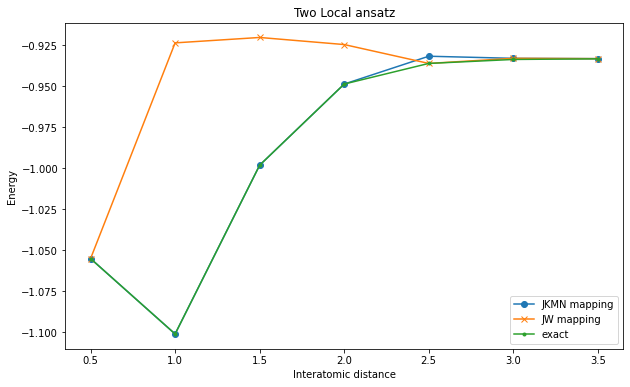

In [22]:
import matplotlib.pyplot as plt

if useTwoLocalAnsatz:
    name = 'Two Local ansatz'
else:
    name = 'UCCSD ansatz'
plt.figure(figsize=(10,6) )
plt.plot(distances,np.real(energies_JKMN), marker='o',  label= 'JKMN mapping')
plt.plot(distances,np.real(energies_JW), marker='x',label= 'JW mapping')
plt.plot(distances,np.real(energies_exact), marker='.', label= 'exact')
plt.title(name)
plt.xlabel('Interatomic distance')
plt.ylabel('Energy')
plt.legend()
plt.savefig(name+'.png')

### Single energy evaluation JW vs JKMN

In [18]:
from qiskit.algorithms import VQE
from qiskit.opflow.converters import CircuitSampler
from qiskit.opflow import CircuitStateFn
from qiskit.utils.backend_utils import is_aer_provider
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit.utils import QuantumInstance
from qiskit.providers import aer
from qiskit_nature.drivers.second_quantization.pyscfd import PySCFDriver
from qiskit_nature.drivers import UnitsType
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
from JKMN_mapper import JKMNMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit.circuit.library.n_local import TwoLocal
from qiskit.algorithms.optimizers import L_BFGS_B,SPSA, COBYLA
from qiskit_nature.circuit.library.initial_states import HartreeFock
from qiskit_nature.circuit.library import UCCSD,UCC,PUCCD,EvolvedOperatorAnsatz
from qiskit.circuit import QuantumCircuit





quantum_instance = QuantumInstance(backend=aer.AerSimulator(method='statevector'))

# Initialize qubit converter
qubit_converter_PM = QubitConverter(mapper=ParityMapper())
qubit_converter_JKMN = QubitConverter(mapper=JKMNMapper())
qubit_converter_JW = QubitConverter(mapper=JordanWignerMapper())
qubit_converter_BK = QubitConverter(mapper=BravyiKitaevMapper())

molecule = 'H .0 .0 .0; H .0 .0 0.5'

#initialize driver & electronic problem
driver = PySCFDriver(atom=molecule, unit=UnitsType.ANGSTROM, basis='sto3g')
qmolecule = driver.run()
num_particles = qmolecule.num_alpha,qmolecule.num_beta

es_problem = ElectronicStructureProblem(driver,
                                        q_molecule_transformers=[FreezeCoreTransformer(freeze_core=True, remove_orbitals=[])])

params_to_evaluate = [0,0]#,0,0,0,0,0,0]

# params_to_evaluate= calc_jw.solver.optimal_params

fermionic_hamiltonian_complete = es_problem.second_q_ops()[0]
fermionic_hamiltonian_1 = FermionicOp(fermionic_hamiltonian_complete.to_list())#+fermionic_hamiltonian_complete.to_list()[6:])
fermionic_hamiltonian_2 = FermionicOp(fermionic_hamiltonian_complete.to_list()[5:6])

# fermionic_hamiltonian = FermionicOp(("+-+-",0.31171790573807057)) \
#                       + FermionicOp(("+--+",-0.31171790573807057)) \
#                       + FermionicOp(("-++-",-0.31171790573807057)) \
#                       + FermionicOp(("-+-+",0.31171790573807057))
optimizer = COBYLA(maxiter=10000, tol=1e-10)

print('Fermionic Hamiltonian:\n',fermionic_hamiltonian_complete)

print('Evalutate Ansatz circuit with',params_to_evaluate)
print('Complete Hamiltonian:',fermionic_hamiltonian_complete)

for converter in [qubit_converter_JKMN]:#[qubit_converter_JW, qubit_converter_JKMN, qubit_converter_BK]:
    print('Case:',converter.mapper)
    for fermionic_hamiltonian in [fermionic_hamiltonian_1]:
        
        # Hamiltonian spin converted from Fermionic hamiltonian
        hamiltonian_spin = converter.convert(fermionic_hamiltonian)

        # Define the circuit to use 
        hf_init = HartreeFock(qubit_converter=converter, 
                             num_spin_orbitals = qmolecule.num_molecular_orbitals*2, 
                             num_particles= num_particles )
        
        ansz = UCC(qubit_converter=converter,
                        excitations='s',
                        num_spin_orbitals = qmolecule.num_molecular_orbitals*2, 
                        num_particles= num_particles, 
                        initial_state=hf_init)
        # convert to a state
        # print('bb',converter.convert(FermionicOp("".join('+I+I'))))

        if converter==qubit_converter_JKMN:
            psi = CircuitStateFn(QuantumCircuit(4))
            print('Energy with HF init []:', psi.adjoint().compose(hamiltonian_spin).compose(psi).eval().real)
            for index in [[0],[1],[2],[3],[0,1],[0,2],[0,3],[1,2],[1,3],[2,3],[0,1,2],[0,1,3],[0,2,3],[1,2,3],[0,1,2,3]]:
                qc = QuantumCircuit(4)
                qc.x(index)
                hf_init = qc
                #print('HF init:\n',hf_init, type(hf_init))
                psi = CircuitStateFn(hf_init)
        # easy expectation value, use for small systems only!
                print('Energy with HF init',index,':', psi.adjoint().compose(hamiltonian_spin).compose(psi).eval().real)
        # ansz = TwoLocal(4, [ 'rx'], 'cz',
        #                 entanglement='full', 
        #                 reps=1, 
        #                 parameter_prefix = 'y',)
                        # initial_state=hf_init)

        # Define VQE just to get the energy evaluation
        simplerVQE = VQE(ansatz = ansz,initial_point=[0,0], optimizer = optimizer)
        simplerVQE._circuit_sampler = CircuitSampler(
                    quantum_instance, param_qobj=is_aer_provider(quantum_instance.backend)
                )
        
        
        energy = simplerVQE.get_energy_evaluation(hamiltonian_spin)


        #print('spin Hamiltonian is: \n',hamiltonian_spin)
        
        print('Energy for ',params_to_evaluate,':',energy(params_to_evaluate), '\n\n')


Fermionic Hamiltonian:
   +-+- * (0.16887022768973592+0j)
+ +--+ * (-0.1688702276897356+0j)
+ -++- * (-0.1688702276897356+0j)
+ -+-+ * (0.16887022768973525+0j)
+ IIIN * (-0.25693578239703235+0j)
+ IINI * (-1.4105283677181673+0j)
+ IINN * (0.5383696138547549+0j)
+ INII * (-0.25693578239703235+0j)
+ ININ * (0.7448393703698866+0j)
+ INNI * (0.7072398415444905+0j)
+ NIII * (-1.4105283677181673+0j)
+ NIIN * (0.7072398415444905+0j)
+ NINI * (0.7197060390562392+0j)
+ NNII * (0.5383696138547549+0j)
Evalutate Ansatz circuit with [0, 0]
Complete Hamiltonian:   +-+- * (0.16887022768973592+0j)
+ +--+ * (-0.1688702276897356+0j)
+ -++- * (-0.1688702276897356+0j)
+ -+-+ * (0.16887022768973525+0j)
+ IIIN * (-0.25693578239703235+0j)
+ IINI * (-1.4105283677181673+0j)
+ IINN * (0.5383696138547549+0j)
+ INII * (-0.25693578239703235+0j)
+ ININ * (0.7448393703698866+0j)
+ INNI * (0.7072398415444905+0j)
+ NIII * (-1.4105283677181673+0j)
+ NIIN * (0.7072398415444905+0j)
+ NINI * (0.7197060390562392+0j)
+ NNII

In [2]:
#try to evaluate a fixed state 

In [3]:
# print(hf_init_JW)
# print(hf_init_JKMN)
print(result_jw.raw_result.optimal_parameters)
print(result_jw.groundstate)

print(result_jkmn.raw_result.optimal_parameters)
print(result_jkmn.groundstate)
print(result_jw.raw_result.cost_function_evals)
print(result_jkmn.raw_result.cost_function_evals)

{ParameterVectorElement(t[0]): 1.570796314919925, ParameterVectorElement(t[1]): 1.5707963504420965}
[-5.14328517e-17+1.14967359e-17j  5.00000000e-01-1.90210730e-16j
 -2.48949813e-17+4.16333634e-17j -5.00000000e-01+1.83271836e-16j
 -7.88157872e-17-1.00005109e-16j -5.88611423e-09+1.38777880e-17j
  7.88157872e-17+2.86059543e-18j -1.77610856e-08-2.20072071e-17j
 -7.63278329e-17+9.95255666e-17j  1.22830203e-16-4.57116630e-17j
  4.16333634e-17-3.09664912e-16j  7.81934587e-17-1.13882897e-16j
 -5.00000000e-01+2.08166817e-16j -2.86059394e-18-3.48987318e-17j
  5.00000000e-01-2.77555756e-16j  1.67383837e-17-7.94908880e-17j]
{ParameterVectorElement(t[0]): 0.7786425359987181, ParameterVectorElement(t[1]): -0.7786425707212701}
[ 2.49977173e-01-7.49026129e-16j -2.04381103e-18-4.34025576e-17j
 -2.49977173e-01+4.72865161e-16j -8.29294859e-17-1.67323287e-17j
  7.53377702e-01-1.85673882e-15j  9.40322773e-17-1.21616914e-16j
  2.46622298e-01-6.22934348e-16j -5.96096526e-17-2.14981611e-17j
 -1.94164235e-17+

In [9]:
# hamilJKMN = qubit_converter_JKMN.convert(es_problem.second_q_ops()[0])
# stateJKMN = calc_jkmn.solver.ansatz.bind_parameters(result_jkmn.raw_result.optimal_parameters) #result_jkmn.raw_result.eigenstate
# stateJKMN = result_jkmn.raw_result.eigenstate

# hamilJW = qubit_converter_JW.convert(es_problem.second_q_ops()[0])
# stateJW = calc_jw.solver.ansatz.bind_parameters(result_jw.raw_result.optimal_parameters) # result_mod.raw_result.eigenstate


# for func,state,op in [(calc_jw,stateJW,hamilJW), (calc_jw,stateJKMN,hamilJKMN)]:
#     print(func.evaluate_operators(state=state, operators=op))

In [ ]:
# hamiltonian = qubit_converter_JW.convert(es_problem.second_q_ops()[0],num_particles=es_problem.num_particles,sector_locator=es_problem.symmetry_sector_locator)
# print(hamiltonian,hamiltonian.eval('0001'))

hamiltonian = qubit_converter_JKMN.convert(es_problem.second_q_ops()[0])#,num_particles=es_problem.num_particles,sector_locator=es_problem.symmetry_sector_locator)
print('JKMN:\n',hamiltonian,hamiltonian.eval('0001'))

hamiltonian = qubit_converter_JKMN.convert_match(es_problem.second_q_ops()[0])#,num_particles=es_problem.num_particles,sector_locator=es_problem.symmetry_sector_locator)
print('JKMN:\n',hamiltonian,hamiltonian.eval('0001'))



# hamiltonian = qubit_converter_PM.convert(es_problem.second_q_ops()[0],num_particles=es_problem.num_particles,sector_locator=es_problem.symmetry_sector_locator)
# print(hamiltonian,hamiltonian.eval('0001'))

[(Pauli('IIXX'), Pauli('IIYX')), (Pauli('IIZX'), Pauli('IXIY')), (Pauli('IYIY'), Pauli('IZIY')), (Pauli('XIIZ'), Pauli('YIIZ'))]
JKMN:
 -0.8105479805373268 * IIII
- 0.225753492224025 * ZIII
+ 0.17218393261915546 * IIZI
+ 0.1661454325638243 * ZIZI
+ 0.1661454325638243 * IIZZ
+ 0.17218393261915543 * IXII
+ 0.12091263261776641 * ZXII
+ 0.16892753870087926 * IXZI
+ 0.12091263261776641 * IXIZ
- 0.225753492224025 * IXZZ
+ 0.17464343068300464 * ZXZZ
+ 0.04523279994605788 * XZXX
- 0.04523279994605788 * YZXY
- 0.04523279994605788 * YYXX
- 0.04523279994605788 * XYXY DictStateFn(defaultdict(<class 'int'>, {'0001': (-0.8641175401421963+0j), '0101': (0.39222153286105504+0j), '1010': 0j, '1110': 0j}))
[(Pauli('IIXX'), Pauli('IIYX')), (Pauli('IIZX'), Pauli('IXIY')), (Pauli('IYIY'), Pauli('IZIY')), (Pauli('XIIZ'), Pauli('YIIZ'))]
JKMN:
 -0.8105479805373268 * IIII
- 0.225753492224025 * ZIII
+ 0.17218393261915546 * IIZI
+ 0.1661454325638243 * ZIZI
+ 0.1661454325638243 * IIZZ
+ 0.17218393261915543 * IXII

## TESTING

In [8]:
from qiskit.opflow import PauliSumOp
from qiskit.quantum_info.operators import Pauli,SparsePauliOp
import numpy as np
from qiskit_nature.operators.second_quantization import FermionicOp

from qiskit_nature.mappers.second_quantization.qubit_mapper import QubitMapper
def jwmap(second_q_op: FermionicOp) -> PauliSumOp:

        # number of modes/sites for the Jordan-Wigner transform (= number of fermionic modes)
        nmodes = second_q_op.register_length

        pauli_table = []
        for i in range(nmodes):
            a_z = np.asarray([1] * i + [0] + [0] * (nmodes - i - 1), dtype=bool)
            a_x = np.asarray([0] * i + [1] + [0] * (nmodes - i - 1), dtype=bool)
            b_z = np.asarray([1] * i + [1] + [0] * (nmodes - i - 1), dtype=bool)
            b_x = np.asarray([0] * i + [1] + [0] * (nmodes - i - 1), dtype=bool)
            # c_z = np.asarray([0] * i + [1] + [0] * (nmodes - i - 1), dtype=bool)
            # c_x = np.asarray([0] * nmodes, dtype=bool)
            pauli_table.append((Pauli((a_z, a_x)), Pauli((b_z, b_x))))
            # TODO add Pauli 3-tuple to lookup table

        return QubitMapper.mode_based_mapping(second_q_op, pauli_table),pauli_table

In [10]:
# m,n = jwmap(FermionicOp(('+-+-', (0.19679058348547018+0j))))
cre = FermionicOp(("+III",1))
ann = FermionicOp(("II+I",1))

from JKMN_mapper import JKMNMapper
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
jkmn = JKMNMapper()
pm = ParityMapper()
jw = JordanWignerMapper()


gamma_0 = cre + ann
# gamma_0 = FermionicOp(("+I",1j))  - FermionicOp(("-I",1j))

m1,ptable = jwmap(cre)
m2,_= jwmap(ann)
m3,_ = jwmap(gamma_0)

m1 = jw.map(cre)
m2 = jw.map(ann)
m3 = jw.map(gamma_0)

p1 = pm.map(cre)
p2 = pm.map(ann)
p3 = pm.map(gamma_0)



jk1 = jkmn.map(cre)
jk2 = jkmn.map(ann)
jk3 = jkmn.map(gamma_0)

print('jw mapping: \n',m1,' and\n ',m2,' \n is: \n',m3,' \n')
# print('parity mapping:\n',p1,' and\n ',p2, '\n is: \n', p3)
print('jkmn mapping:\n',jk1,' and\n ',jk2, '\n is: \n', jk3)


jw mapping: 
 0.5 * IIIX
+ 0.5j * IIIY  and
  0.5 * IXZZ
+ 0.5j * IYZZ  
 is: 
 0.5 * IXZZ
+ 0.5j * IYZZ
+ 0.5 * IIIX
+ 0.5j * IIIY  

jkmn mapping:
 0.5 * XXII
+ 0.5j * XYII  and
  0.5j * YIZI
+ 0.5 * YIYI 
 is: 
 0.5j * YIZI
+ 0.5 * XXII
+ 0.5j * XYII
+ 0.5 * YIYI


In [10]:
first = SparsePauliOp(Pauli('XX'),coeffs=[0.5])+SparsePauliOp(Pauli('YX'), coeffs=[0.5j])
print(first.to_list())
second = SparsePauliOp(Pauli('ZX'),coeffs=[0.5])+SparsePauliOp(Pauli('IY'),coeffs=[0.5j])
print(second.to_list())
comb = first&second
print(comb.to_list())


[('XX', (0.5+0j)), ('YX', 0.5j)]
[('ZX', (0.5+0j)), ('IY', 0.5j)]
[('YI', 0.25j), ('XZ', (0.25-0j)), ('XI', (0.25-0j)), ('YZ', 0.25j)]


In [ ]:
a,b = nevenrun(2)
print('JW \t', ptable)
print('JWKM \t',a )

JW 	 [(Pauli('IX'), Pauli('IY')), (Pauli('XZ'), Pauli('YZ'))]
JWKM 	 [(Pauli('XX'), Pauli('YX')), (Pauli('ZX'), Pauli('IY'))]


In [ ]:
from JKMN_mapper import JKMNMapper

gamma_0 = FermionicOp(("+",1)) + FermionicOp(("-",1))
gamma_1 = FermionicOp(("+",1j)) - FermionicOp(("-",1j))

abc = JKMNMapper()

abc.map(gamma_0)

[(Pauli('X'), Pauli('Y'))]


PauliSumOp(SparsePauliOp([[ True, False]],
              coeffs=[1.+0.j]), coeff=1.0)

In [ ]:
FermionicOp('+')

FermionicOp([('+', (1+0j))], register_length=1, sparse_label=False)